In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import sys
from tqdm import tqdm
import tensorflow as tf

sys.path.append('../../ieegpy/ieeg')
sys.path.append('code/tools')
sys.path.append('code')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import keras as K


# sets path to one directory up from where code is
path = "/".join(os.path.abspath(os.getcwd()).split('/')[:-1])

import json
import numpy as np
import pandas as pd
from get_iEEG_data import get_iEEG_data
from plot_iEEG_data import plot_iEEG_data
from line_length import line_length
from get_iEEG_duration import get_iEEG_duration
import csv_utils
import segmentation
import feature_extraction
import preprocess

In [10]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16691425482182547583
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6938689536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11581807957459587432
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:2d:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [12]:
with open("credentials.json") as f:
    credentials = json.load(f)
    username = credentials['username']
    password = credentials['password']

In [13]:
metadata = pd.read_csv('ieeg_metadata.csv')
metadata.describe()

,Unnamed: 0,Seizure number,Seizure EEC,Seizure UEO,Seizure end,Seizure duration
count,256.000000,256.000000,2.560000e+02,2.560000e+02,2.560000e+02,256.000000
mean,161.523438,3.808594,3.850046e+05,3.850087e+05,3.850987e+05,89.983726
std,105.468253,4.411047,2.512188e+05,2.512184e+05,2.512276e+05,107.030035
min,0.000000,0.000000,1.422600e+04,1.422600e+04,1.425995e+04,4.900000
25%,64.750000,1.000000,2.076900e+05,2.076916e+05,2.077277e+05,34.252500
50%,155.500000,2.000000,3.487700e+05,3.487708e+05,3.490025e+05,67.945000
75%,255.250000,5.000000,5.301436e+05,5.301436e+05,5.302733e+05,91.760000
max,364.000000,22.000000,1.694568e+06,1.694570e+06,1.694644e+06,781.950000


In [14]:
seizure_data = csv_utils.read_pickle('data/seizure/seizure_clips_data', 256)
seizure_time = csv_utils.read_pickle('data/seizure_time/seizure_time_data', 256)
for i in range(len(seizure_data)):
    seizure_data[i] = seizure_data[i].dropna(axis='columns')

In [15]:
nonseizure_data = csv_utils.read_pickle('data/non_seizure/nonseizure_clips_data', 256)
nonseizure_time = csv_utils.read_pickle('data/non_seizure_time/nonseizure_time_data', 256)
for i in range(len(nonseizure_data)):
    nonseizure_data[i] = nonseizure_data[i].dropna(axis='columns')

In [16]:
# seizure_data,seizure_time = csv_utils.seizure_clip_read(metadata, username, password)
# csv_utils.dump_pickle(seizure_data,'data/seizure/seizure_clips_data')
# csv_utils.dump_pickle(seizure_time,'data/seizure_time/seizure_time_data')

In [17]:
# nonseizure_data, nonseizure_time = csv_utils.nonseizure_clip_read(metadata, username, password)
# csv_utils.dump_pickle(nonseizure_data,'data/non_seizure/nonseizure_clips_data')
# csv_utils.dump_pickle(nonseizure_time,'data/non_seizure_time/nonseizure_time_data')

In [18]:
window_len = 2
stride = 1
seizure_data_windowed = []
for i in tqdm(range(len(seizure_data))):
    fs = segmentation.get_fs(seizure_time[i])
    if fs == 512:
        seg = segmentation.get_windoweds(seizure_data[i].to_numpy(), fs, window_len, stride)
        seizure_data_windowed.append(seg)
window_len = 2
stride = 1
nonseizure_data_windowed = []
for i in tqdm(range(len(nonseizure_data))):
    fs = segmentation.get_fs(nonseizure_time[i])
    if fs == 512:
        seg = segmentation.get_windoweds(nonseizure_data[i].to_numpy(), fs, window_len, stride)
        nonseizure_data_windowed.append(seg)

100%|██████████| 256/256 [00:24<00:00, 10.64it/s] 


In [19]:
seizure_data_windowed[1].shape

(78, 1024, 82)

In [20]:
channel_n = 90
fs = 512
seizure_channel_indices = []
nonseizure_channel_indices = []
seizure_data_stack = np.empty((0, fs * 2, channel_n))
for i,c in enumerate(seizure_data_windowed):
    if c.shape[2] == channel_n:
        seizure_channel_indices.append(i)
        seizure_data_stack = np.vstack((seizure_data_stack, c))
for i,c in enumerate(nonseizure_data_windowed):
    if c.shape[2] == channel_n:
        nonseizure_channel_indices.append(i)
        seizure_data_stack = np.vstack((seizure_data_stack, c))

In [21]:
seizure_channel_indices

[4, 5, 6, 7, 8, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 59, 60]

In [22]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, BatchNormalization,GlobalAveragePooling2D, Input, Reshape, UpSampling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import schedules, SGD, Adam
import tensorflow as tf
from sklearn import preprocessing
from matplotlib import pyplot as plt
from keras import backend as K

In [23]:
dg_min, dg_max = preprocess.normalization_fit_stack(seizure_data_stack)
seizure_data_norm = preprocess.normalize_stack(seizure_data_stack,dg_min,dg_max)

In [24]:
K.clear_session()

In [25]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [26]:
from autoencoder import Autoencoder
ae = Autoencoder(seizure_data_stack.shape[1],seizure_data_stack.shape[2])

In [27]:
# callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
#     min_delta=1e-6,
#     patience=20,restore_best_weights=True)
# ae.build(input_shape = (None,seizure_data_norm.shape[1],seizure_data_norm.shape[2]))
# ae.summary()
# opt = keras.optimizers.Adam(learning_rate=3e-5)
# ae.compile(optimizer=opt, loss='mse')
# ae.fit(seizure_data_norm, seizure_data_norm,
#           epochs=100,
#           batch_size=16,callbacks = [callback],
#           validation_data=(seizure_data_norm, seizure_data_norm))

In [28]:
# ae.encoder.save("encoder.h5")
# ae.decoder.save("decoder.h5")

In [29]:
ae.encoder = tf.keras.models.load_model("encoder.h5")
ae.decoder = tf.keras.models.load_model("decoder.h5")

In [30]:
with tf.device('/cpu:0'):
    encode = ae.encoder.predict(seizure_data_norm)
    decode = ae.decoder.predict(encode)

69/69 [==============================] - 7s 99ms/step


In [31]:
decode.shape

(2192, 1024, 90)

In [32]:
from sklearn.metrics import mean_squared_error
mean_squared_error(seizure_data_norm[3], decode[3])

0.0009358597594918698

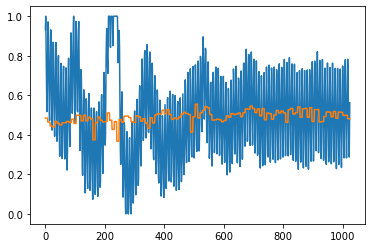

In [33]:
plt.plot(seizure_data_norm[160,:,-1])
plt.plot(decode[160,:,-1])

In [34]:
# plot_iEEG_data(seizure_data[seizure_channel_indices[0]], seizure_time[seizure_channel_indices[0]])

In [35]:
encode = encode[:,:,0,:]

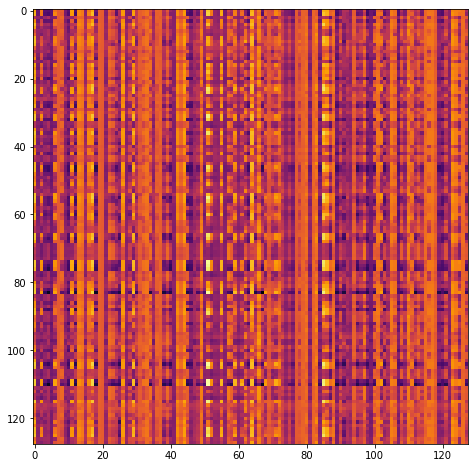

In [36]:
plt.figure(figsize=(8, 8))
plt.imshow(encode[150], cmap='inferno')
plt.show()

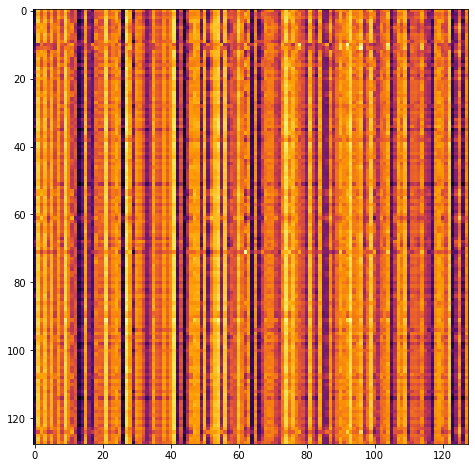

In [37]:
plt.figure(figsize=(8, 8))
plt.imshow(encode[1300+120], cmap='inferno', interpolation='nearest')
plt.show()

In [38]:
from sklearn.decomposition import PCA

In [39]:
dt_len = int(seizure_data_stack.shape[0]/2)
reduced_seizure = np.zeros((dt_len,128,128))
reduced_nonseizure = np.zeros((dt_len,128,128))
for i in tqdm(range(dt_len)):
    pca_seizure = PCA()
    reduced_seizure[i] = pca_seizure.fit_transform(encode[i])
for i in tqdm(range(dt_len)):
    pca_nonseizure = PCA()
    reduced_nonseizure[i] = pca_nonseizure.fit_transform(encode[i+dt_len])

100%|██████████| 1096/1096 [00:01<00:00, 739.87it/s]


In [40]:
var11 = np.sum(np.var(encode[:dt_len],axis=2)**2,axis=1)
var21 = np.sum(np.var(encode[:dt_len],axis=1)**2,axis=1)
var12 = np.sum(np.var(encode[dt_len:],axis=2)**2,axis=1)
var22 = np.sum(np.var(encode[dt_len:],axis=1)**2,axis=1)

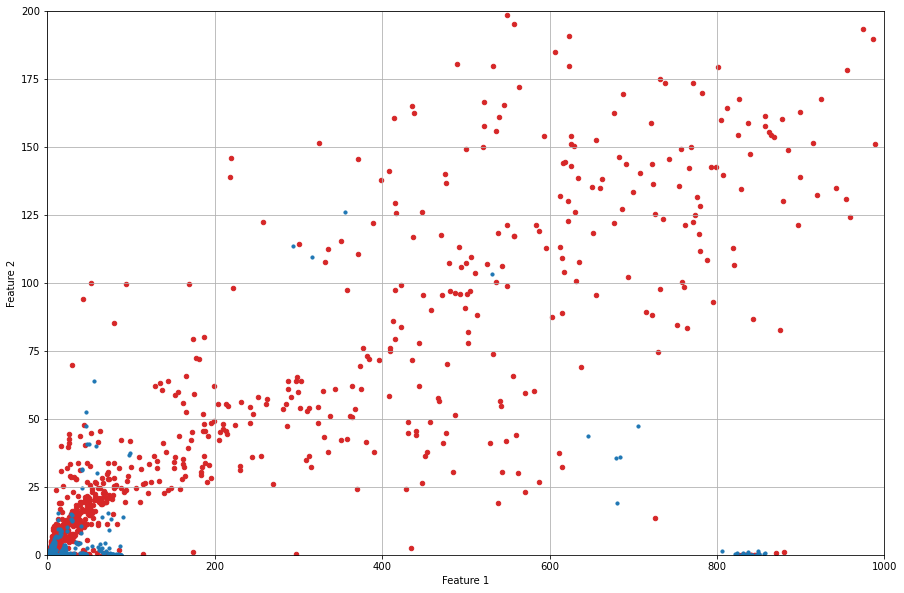

In [41]:
reduced_seizure_space = np.sum(reduced_seizure[:,:,:]**2,axis=1)
reduced_nonseizure_space = np.sum(reduced_nonseizure[:,:,:]**2,axis=1)
plt.figure(figsize=(15, 10))
# plt.scatter(reduced_nonseizure_space[:,0],reduced_nonseizure_space[:,1],color='tab:blue')
# plt.scatter(reduced_seizure_space[:,0],reduced_seizure_space[:,1],color='tab:red')
# plt.scatter(reduced_seizure[:,:,0],reduced_seizure[:,:,1],color='tab:red')
# plt.scatter(reduced_nonseizure[:,:,0],reduced_nonseizure[:,:,1],color='tab:blue')
plt.scatter(var11,var21,color='tab:red',alpha=1, s = 20)
plt.scatter(var12,var22,color='tab:blue',alpha=1, s = 10)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
# plt.xlim((0,20))
# plt.ylim((0,2))
plt.xlim((0,1000))
plt.ylim((0,200))
plt.grid(zorder = 4)
plt.show()

In [121]:
from keras.applications import xception

In [122]:
xception_model = xception.Xception(include_top=False,
    weights="imagenet",
    pooling='max',
    classes=512,
    classifier_activation=None,input_shape=(128, 128, 3))
# x = xception_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(2, activation='softmax')(x)
# # xception_model.add(Dense(1024,activation='relu'))
# # xception_model.add(Dense(2,activation='softmax'))
# transfer_model = Model(inputs=xception_model.input, outputs=predictions)
# transfer_model.summary()

In [165]:
model = Sequential()
model.add(Input(shape=(128,128)))
model.add(Reshape((128,128,1)))
model.add(Dense(3))
model.add(Reshape((128,128,3)))
model.add(xception_model)
model.add(Dense(128,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.build()
opt = Adam(learning_rate=1e-5, beta_1=0.995)
callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=1e-6,patience=10,restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_31 (Reshape)        (None, 128, 128, 1)       0         
                                                                 
 dense_44 (Dense)            (None, 128, 128, 3)       6         
                                                                 
 reshape_32 (Reshape)        (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_45 (Dense)            (None, 128)               262272    
                                                                 
 dense_46 (Dense)            (None, 2)                 258       
                                                                 
Total params: 21,124,016
Trainable params: 21,069,488

In [229]:
y = np.hstack((np.ones(1096),np.zeros(1096)))

In [167]:
def convert2onehot(labels):
  result = []
  for label in labels:
    if label == 1:
      result.append([1, 0])
    else:
      result.append([0, 1])
  return np.array(result)

In [168]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encode, y, test_size=0.2, random_state=1)

In [169]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [170]:
y_train_onehot = convert2onehot(y_train)
y_val_onehot = convert2onehot(y_val)

In [171]:
model.fit(X_train, y_train_onehot, batch_size=8, epochs=20, validation_data=(X_val, y_val_onehot),callbacks=[callback])

Epoch 1/20
165/165 [==============================] - 15s 73ms/step - loss: 0.5219 - accuracy: 0.7397 - val_loss: 0.4064 - val_accuracy: 0.8200
Epoch 2/20
165/165 [==============================] - 12s 70ms/step - loss: 0.4173 - accuracy: 0.8128 - val_loss: 0.3768 - val_accuracy: 0.8292
Epoch 3/20
165/165 [==============================] - 12s 71ms/step - loss: 0.3821 - accuracy: 0.8189 - val_loss: 0.3534 - val_accuracy: 0.8383
Epoch 4/20
165/165 [==============================] - 12s 71ms/step - loss: 0.3645 - accuracy: 0.8333 - val_loss: 0.3376 - val_accuracy: 0.8451
Epoch 5/20
165/165 [==============================] - 12s 71ms/step - loss: 0.3408 - accuracy: 0.8440 - val_loss: 0.3137 - val_accuracy: 0.8656
Epoch 6/20
165/165 [==============================] - 12s 71ms/step - loss: 0.3186 - accuracy: 0.8615 - val_loss: 0.2968 - val_accuracy: 0.8702
Epoch 7/20
165/165 [==============================] - 12s 71ms/step - loss: 0.3112 - accuracy: 0.8577 - val_loss: 0.2960 - val_accuracy:

In [172]:
import math
def tolabel(x):
  smx0 = math.exp(x[0])/(math.exp(x[0])+math.exp(x[1]))
  smx1 = math.exp(x[1])/(math.exp(x[0])+math.exp(x[1]))
  if smx0 > smx1:
    return 1
  else:
    return 0

In [173]:
prediction = []
predict_pair = model.predict(X_test)
for pair in predict_pair:
  prediction.append(tolabel(pair))

14/14 [==============================] - 1s 50ms/step


In [174]:
from sklearn.metrics import accuracy_score
accuracy_score(prediction, y_test)

0.8519362186788155

In [175]:
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[-2].output])
with tf.device('/cpu:0'):
    layer_output = get_3rd_layer_output(encode)[0]

In [176]:
layer_output.shape

(2192, 128)

In [177]:
pca_seizure = PCA()
reduced = pca_seizure.fit_transform(layer_output)

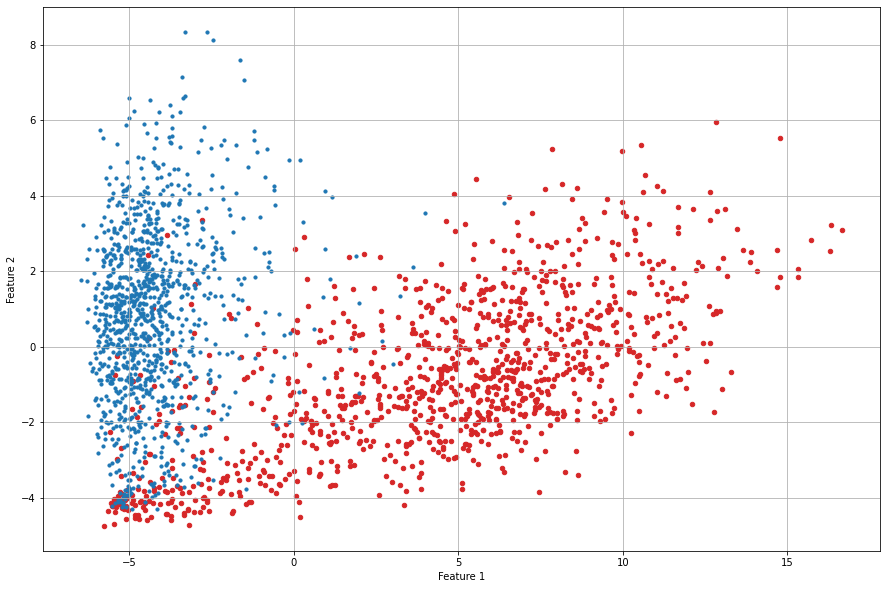

In [182]:
plt.figure(figsize=(15, 10))
# plt.scatter(reduced_nonseizure_space[:,0],reduced_nonseizure_space[:,1],color='tab:blue')
# plt.scatter(reduced_seizure_space[:,0],reduced_seizure_space[:,1],color='tab:red')
# plt.scatter(reduced_seizure[:,:,0],reduced_seizure[:,:,1],color='tab:red')
# plt.scatter(reduced_nonseizure[:,:,0],reduced_nonseizure[:,:,1],color='tab:blue')
plt.scatter(reduced[:dt_len,0],reduced[:dt_len,1],color='tab:red',alpha=1, s = 20)
plt.scatter(reduced[dt_len:,0],reduced[dt_len:,1],color='tab:blue',alpha=1, s = 10)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
# plt.xlim((0,20))
# plt.ylim((0,2))
plt.grid(zorder = 4)
plt.show()

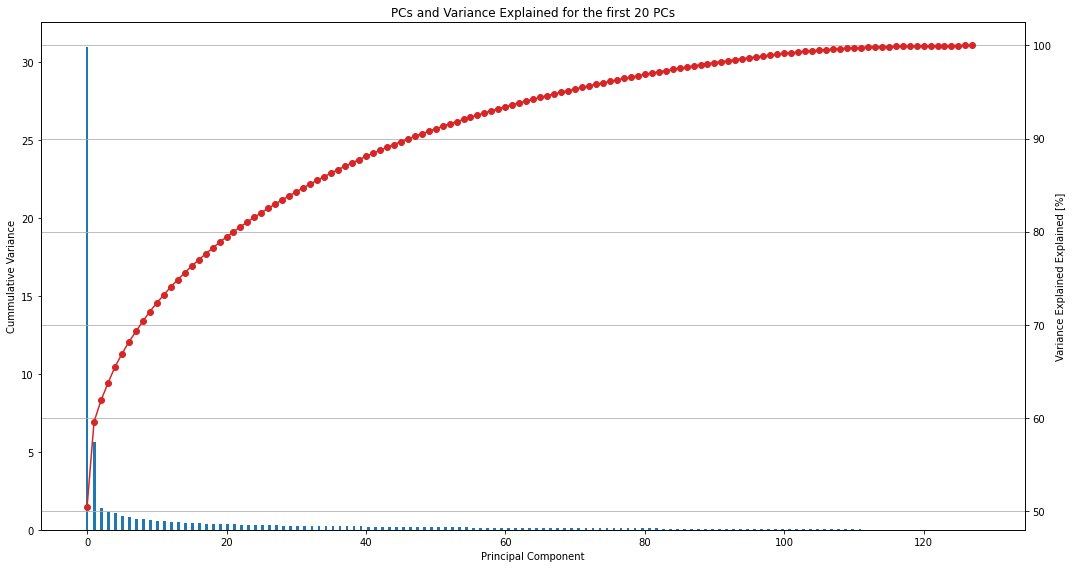

In [184]:
ev_seizure = pca_seizure.explained_variance_
ev = ev_seizure
bar_x = np.linspace(0,128,128)
cum_pv = np.cumsum(ev)/np.sum(ev)*100

fig,ax = plt.subplots(figsize=(15, 8))
ax.bar(bar_x,ev, color ='tab:blue',width = 0.4)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Cummulative Variance")
ax.set_title("PCs and Variance Explained for the first 20 PCs")
ax2 = ax.twinx()

ax2.plot(cum_pv,'-o',color = 'tab:red')
ax2.set_ylabel("Variance Explained Explained [%]")
ax2.grid()
fig.tight_layout()


plt.show()

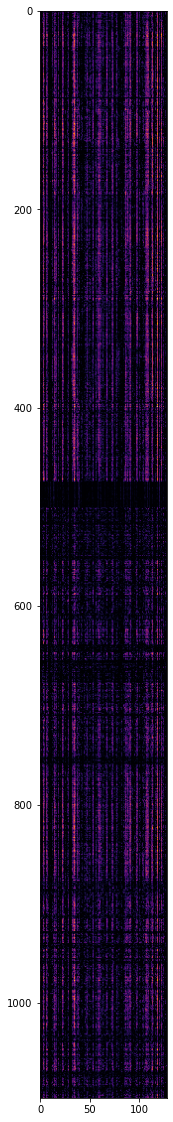

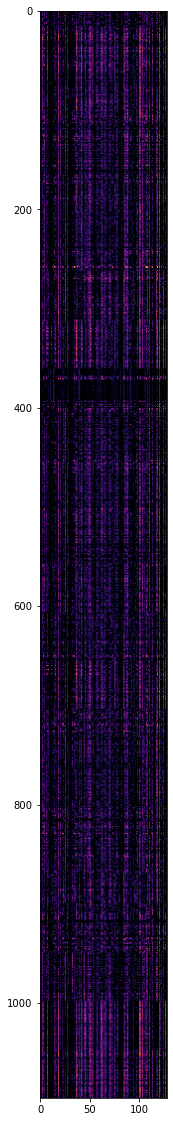

In [189]:
plt.figure(figsize=(8, 20))
plt.imshow(layer_output[:1096], cmap='inferno')
plt.show()

plt.figure(figsize=(8, 20))
plt.imshow(layer_output[1096:], cmap='inferno')
plt.show()

In [208]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=142)
z = tsne.fit_transform(encode.reshape((encode.shape[0],128*128)))
# plt.scatter(reduced_nonseizure_space[:,0],reduced_nonseizure_space[:,1],color='tab:blue')
# plt.scatter(reduced_seizure_space[:,0],reduced_seizure_space[:,1],color='tab:red')
# plt.scatter(reduced_seizure[:,:,0],reduced_seizure[:,:,1],color='tab:red')
# plt.scatter(reduced_nonseizure[:,:,0],reduced_nonseizure[:,:,1],color='tab:blue')

C:\ProgramData\Anaconda3_1\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3_1\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2192 samples in 0.015s...
[t-SNE] Computed neighbors for 2192 samples in 0.980s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2192
[t-SNE] Computed conditional probabilities for sample 2000 / 2192
[t-SNE] Computed conditional probabilities for sample 2192 / 2192
[t-SNE] Mean sigma: 8.054071
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.603714
[t-SNE] KL divergence after 1000 iterations: 1.056497


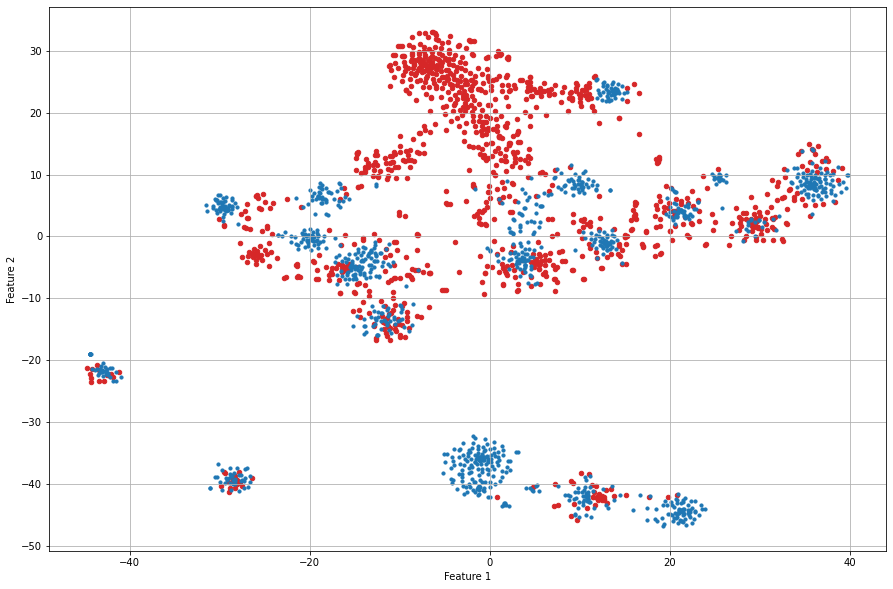

In [230]:
plt.figure(figsize=(15, 10))
plt.scatter(z[:dt_len,0],z[:dt_len,1],color='tab:red',alpha=1, s = 20)
plt.scatter(z[dt_len:,0],z[dt_len:,1],color='tab:blue',alpha=1, s = 10)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
# plt.xlim((0,20))
# plt.ylim((0,2))
plt.grid(zorder = 4)
plt.show()

In [235]:
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
gm = GaussianMixture(n_components=2, random_state=0,covariance_type ='spherical')
# gm = KNeighborsClassifier(n_neighbors=1)
gm.fit(z,y)

GaussianMixture(covariance_type='spherical', n_components=2, random_state=0)

In [236]:
# create the mesh
nx, ny = (1000, 1000)
x = np.linspace(-50, 50, nx)
y = np.linspace(-50, 50, ny)
xv, yv = np.meshgrid(x, y, indexing='ij')
gm_predict = np.ones(nx*ny).reshape((nx,ny))
# calculate the value of the point in the mesh
for i in tqdm(range(nx)):
    for j in range(ny):
      gm_predict[i,j] = gm.predict(np.array([x[i],y[j]]).reshape(1, -1))

100%|██████████| 1000/1000 [00:55<00:00, 17.98it/s]


<ipython-input-237-feef04f279ce>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(xv, yv, gm_predict,cmap=cmap,alpha = 0.3)


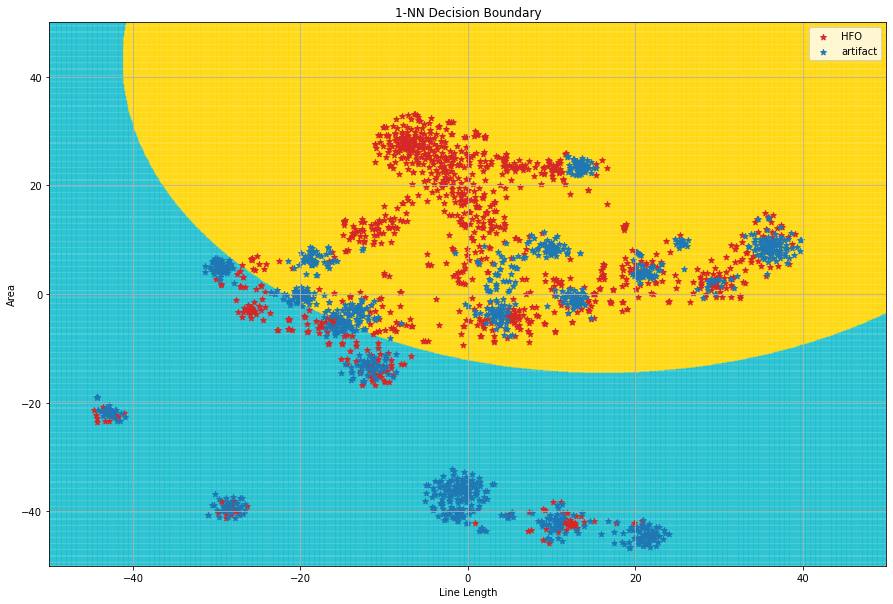

In [237]:
from matplotlib import colors
cmap = colors.ListedColormap(['gold', 'tab:cyan'])
plt.figure(figsize=(15, 10))
plt.pcolor(xv, yv, gm_predict,cmap=cmap,alpha = 0.3)
plt.scatter(z[:dt_len,0],z[:dt_len,1],marker='*', label = "HFO", color = "tab:red")
plt.scatter(z[dt_len:,0],z[dt_len:,1],marker='*', label = "artifact", color = "tab:blue")
plt.title("1-NN Decision Boundary")
plt.xlabel("Line Length")
plt.ylabel("Area")
plt.legend()
plt.grid()
plt.show()

In [238]:
print("The training score is: " + str(gm.score(z,y)))

The training score is: -8.729452628776256


In [239]:
z

array([[  6.65882  ,   7.3731117],
       [  4.311795 ,  11.928028 ],
       [  5.7865243,  10.351625 ],
       ...,
       [  0.5614776, -35.52271  ],
       [ -1.0121319, -36.14815  ],
       [ -1.013011 , -36.082253 ]], dtype=float32)

In [226]:
y.shape

(1000,)